# Day3課題

目的  
* E10とSP98のどちらがコストパフォーマンスがいいかを考える  


項目  
* distance:走行距離  
* consume:車に表示される100Km当たりの消費燃料
* speed:走行時の平均速度  
* temp_inside:暖房の設定温度、NaNは暖房オフ  
* temp_outside:外気温  
* specials:特筆事項、以下の項目にホットエンコードとして存在している  
* gas_type:燃料の種類  
* AC:エアコンがACモードであるか(?)  
* rain:雨や雪が降っていた  
* sun:よく晴れていた  
* refill liters:給油した量
* refill gas:給油した種類

# 目次  
  1.  

学習後の重みを見ればわかるのではないかと想像

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split, KFold # 交差検証法に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFECV

## 1. データの読み込み 

In [2]:
df_car_consume = pd.read_csv("car-consume/measurements.csv", decimal=",")[['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'specials', 'gas_type', 'AC', 'rain', 'sun', 'refill liters', 'refill gas']]

# データ
display(df_car_consume.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


## 2. データの整理

### 2-1. 小数点の整形  
decimal=","を引数に加えたことで必要なくなった

### 2-2.ダミー変数の利用

In [3]:
# specialsはすでに別項目で存在しているのでドロップ
df_car_consume = df_car_consume.drop('specials', axis=1)

df_car_consume = pd.get_dummies(df_car_consume)

### 2-3.その他コンバート項目

In [4]:
# refill litersの欠損は給油無として0埋め
df_car_consume['refill liters'] = df_car_consume['refill liters'].fillna(0)

# 暖房のオンオフ判断
df_car_consume['heating_off'] = df_car_consume['temp_inside'].isnull().astype(int)

# temp_insideの欠損は暖房がオフのため外部気温と同じとみなしてtemp_outside代入
df_car_consume['temp_inside'] = df_car_consume['temp_inside'].fillna(df_car_consume['temp_outside'])

# 内外の気温差
df_car_consume['temp_diff'] = df_car_consume['temp_inside'] - df_car_consume['temp_outside']

In [5]:
display(df_car_consume.head())

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,heating_off,temp_diff
0,28.0,5.0,26,21.5,12,0,0,0,45.0,1,0,1,0,0,9.5
1,12.0,4.2,30,21.5,13,0,0,0,0.0,1,0,0,0,0,8.5
2,11.2,5.5,38,21.5,15,0,0,0,0.0,1,0,0,0,0,6.5
3,12.9,3.9,36,21.5,14,0,0,0,0.0,1,0,0,0,0,7.5
4,18.5,4.5,46,21.5,15,0,0,0,0.0,1,0,0,0,0,6.5


## 3. データの分析

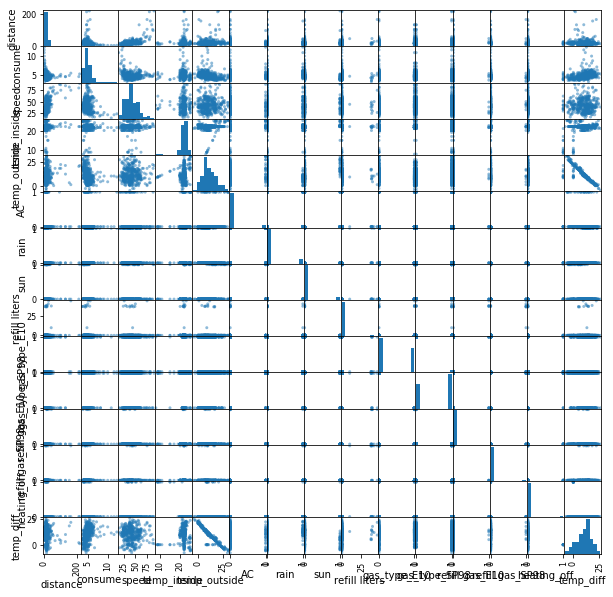

In [6]:
# 散布図行列
pd.plotting.scatter_matrix(df_car_consume, figsize=(10,10))
plt.show()

In [7]:
# 相関係数を確認
df_car_consume.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,heating_off,temp_diff
distance,1.000000,-0.128967,0.562299,0.072861,0.088175,-0.025738,-0.019791,0.081120,0.107045,0.053411,-0.053411,0.026079,0.106134,-0.035730,-0.066895
consume,-0.128967,1.000000,-0.227866,-0.035716,-0.320811,0.096591,0.248118,-0.170667,-0.074095,0.015327,-0.015327,-0.025731,-0.079080,-0.069953,0.313642
speed,0.562299,-0.227866,1.000000,0.026292,0.015411,-0.035408,0.009489,0.081618,-0.007446,0.097360,-0.097360,-0.073428,0.046177,-0.012205,-0.007539
temp_inside,0.072861,-0.035716,0.026292,1.000000,0.189519,0.182160,-0.010193,0.127052,0.016573,0.063965,-0.063965,0.009738,0.013224,-0.820054,0.114541
temp_outside,0.088175,-0.320811,0.015411,0.189519,1.000000,0.167562,-0.186315,0.346903,-0.041595,-0.148705,0.148705,-0.009135,-0.043809,0.014287,-0.953707
AC,-0.025738,0.096591,-0.035408,0.182160,0.167562,1.000000,0.242915,0.088598,-0.052571,-0.105285,0.105285,-0.033075,-0.042002,-0.051715,-0.113738
rain,-0.019791,0.248118,0.009489,-0.010193,-0.186315,0.242915,1.000000,-0.112650,0.033505,-0.060328,0.060328,0.026474,0.055653,-0.021909,0.185383
sun,0.081120,-0.170667,0.081618,0.127052,0.346903,0.088598,-0.112650,1.000000,-0.054448,-0.022761,0.022761,-0.034256,-0.043501,0.000558,-0.312066
refill liters,0.107045,-0.074095,-0.007446,0.016573,-0.041595,-0.052571,0.033505,-0.054448,1.000000,-0.000741,0.000741,0.640010,0.727194,-0.032443,0.047160
gas_type_E10,0.053411,0.015327,0.097360,0.063965,-0.148705,-0.105285,-0.060328,-0.022761,-0.000741,1.000000,-1.000000,0.136393,-0.121547,-0.058926,0.170045


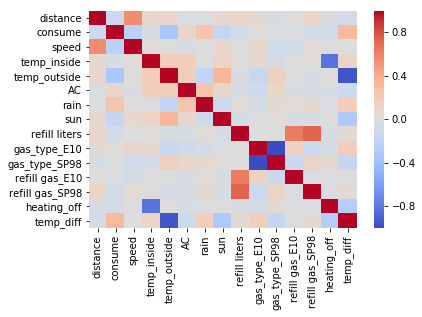

In [8]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_car_consume.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [9]:
df_car_consume.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,heating_off,temp_diff
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.619845,11.358247,0.077320,0.123711,0.082474,1.243557,0.412371,0.587629,0.012887,0.020619,0.030928,10.261598
std,22.667837,1.033172,13.598524,2.116551,6.991542,0.267443,0.329677,0.275441,6.856419,0.492897,0.492897,0.112931,0.142287,0.173346,6.910315
min,1.300000,3.300000,14.000000,8.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,11.500000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,14.625000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000


distanceの大きいものを外れ値として削除する。  
→本当は標準偏差をもとにしたりしてみたいがどうやればいいのか。。

In [10]:
df_car_consume = df_car_consume[df_car_consume['distance'] < 30]
df_car_consume.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,heating_off,temp_diff
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,14.189244,4.943895,39.688953,21.579942,11.308140,0.084302,0.127907,0.078488,1.131395,0.392442,0.607558,0.011628,0.017442,0.034884,10.271802
std,5.720509,1.083816,11.272625,2.230880,7.015463,0.278245,0.334473,0.269330,6.560070,0.489006,0.489006,0.107360,0.131102,0.183753,6.966462
min,1.300000,3.300000,14.000000,8.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.000000
25%,11.800000,4.300000,32.000000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
50%,13.000000,4.800000,39.000000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,11.500000
75%,16.600000,5.300000,47.000000,22.500000,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,14.625000
max,29.900000,12.200000,71.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000


## 4.特徴変数の選択

今回は特徴量が少ないのでそれほど必要だとは思えないがとりあえずステップワイズ法を試してみる。  
間隔としてはこの3つが必要ないはずだが一致するか？  
* temp_inside:暖房の設定温度であり単体ではパフォーマンスに関わらない
* refill liters:単体での走行とは無関係
* refill gas:同上

### 4-1.白色化  
とりあえず白色化

In [11]:
train_label = df_car_consume["consume"]
train_data = df_car_consume.drop("consume", axis=1)

y = train_label.values
X = train_data.values

In [12]:
#  無相関化を行うための一連の処理
cov = np.cov(X, rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
X_decorr = np.dot(S.T, X.T).T #データを無相関化

stdsc = StandardScaler()
stdsc.fit(X_decorr)
X_whitening  = stdsc.transform(X_decorr) # 無相関化したデータに対して、さらに標準化

特徴量の選択

In [13]:
# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = LinearRegression(normalize=False)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

In [14]:
# fitで特徴選択を実行
rfecv.fit(X_whitening, y)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None,
   scoring='neg_mean_absolute_error', step=1, verbose=0)

In [15]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 3 1 1 2 1 1 1 1 1 1 1 1]


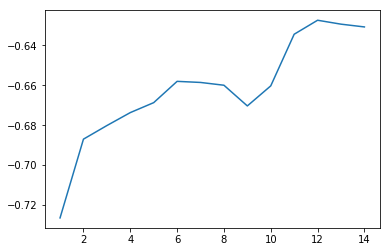

In [16]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [17]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
# 削除してもよい特徴の名前を取得する
remove_feature = train_data.columns[remove_idx]
remove_feature

Index(['temp_inside', 'rain'], dtype='object')

ガスタイプがふたつの項目に分けたものを両方保持しているのがダメだと思うので片方ドロップして再挑戦

In [18]:
train_label = df_car_consume["consume"]
train_data = df_car_consume.drop(["consume",'gas_type_SP98'], axis=1)

y = train_label.values
X = train_data.values

In [19]:
#  無相関化を行うための一連の処理
cov = np.cov(X, rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
X_decorr = np.dot(S.T, X.T).T #データを無相関化

stdsc = StandardScaler()
stdsc.fit(X_decorr)
X_whitening  = stdsc.transform(X_decorr) # 無相関化したデータに対して、さらに標準化

In [20]:
# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = LinearRegression(normalize=False)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

In [21]:
# fitで特徴選択を実行
rfecv.fit(X_whitening, y)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None,
   scoring='neg_mean_absolute_error', step=1, verbose=0)

In [22]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 9 5 1 7 6 4 3 2 8]


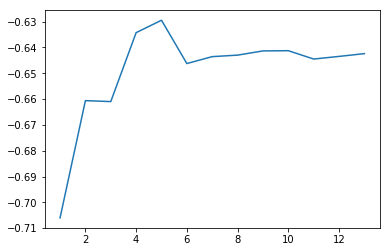

In [23]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [24]:
#残すものを確認
train_data.columns[rfecv.support_]

Index(['distance', 'speed', 'temp_inside', 'temp_outside', 'sun'], dtype='object')

またガスタイプが消えてしまった。  
残った特徴量も天気に関するものばかりしかない。  
とりあえず学習結果が改善されたかどうかを見てみる。

In [25]:
# drop関数で特徴を削除
selected_train_data = train_data.drop(train_data.columns[~rfecv.support_], axis=1)

## 5.特徴量を減らした結果の確認

減らす前  

In [26]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_whitening, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = Ridge(alpha=10, random_state=1234)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.647

Fold 2
MAE = 0.637

Fold 3
MAE = 0.705

Fold 4
MAE = 0.542

Fold 5
MAE = 0.679

Cross Validation MAE = 0.642


減らした後  

In [27]:
n_split = 5 # グループ数を設定（今回は5分割）


cross_valid_mae = 0
split_num = 1

X = selected_train_data.values

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = Ridge(alpha=10, random_state=1234)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.663

Fold 2
MAE = 0.675

Fold 3
MAE = 0.726

Fold 4
MAE = 0.578

Fold 5
MAE = 0.647

Cross Validation MAE = 0.658


悪化した。  
→特徴量を減らすときと検証の時で違う方法を選択したから？

# 6.再度特徴量の選択

In [28]:
# estimatorにモデルをセット
estimator = Ridge(alpha=10, random_state=1234)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

In [29]:
# fitで特徴選択を実行
rfecv.fit(X_whitening, y)

RFECV(cv=10,
   estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1234, solver='auto', tol=0.001),
   min_features_to_select=1, n_jobs=None,
   scoring='neg_mean_absolute_error', step=1, verbose=0)

In [30]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 9 5 1 7 6 4 3 2 8]


変化なし
→ステップワイズ法は変数を削除しないという選択肢は選べないのでは？  

とりあえず今回は特徴量削除しないで進めてみる。

# 7.ニューラルネットワーク

コピペでやってみる

In [31]:
# データの準備
X_train, X_test, y_train, y_test = train_test_split(X_whitening, y, test_size=0.3, random_state=1234)

In [32]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(8, activation='relu', input_dim=13))
model.add(Dense(3, activation='relu', input_dim=8))
model.add(Dense(1, activation='linear'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

# WARNINGが出るが気にしなくて良い

W0809 01:55:18.379977  7960 deprecation.py:506] From C:\Users\sst180333\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 240 samples, validate on 104 samples
Epoch 1/50
240/240 [==============================] - 0s 2ms/sample - loss: 21.9888 - mean_absolute_error: 4.5191 - val_loss: 15.8150 - val_mean_absolute_error: 3.8639
Epoch 2/50
240/240 [==============================] - 0s 222us/sample - loss: 12.6683 - mean_absolute_error: 3.3627 - val_loss: 7.8235 - val_mean_absolute_error: 2.5747
Epoch 3/50
240/240 [==============================] - 0s 420us/sample - loss: 5.1348 - mean_absolute_error: 1.9640 - val_loss: 2.9328 - val_mean_absolute_error: 1.4077
Epoch 4/50
240/240 [==============================] - 0s 337us/sample - loss: 2.2007 - mean_absolute_error: 1.1997 - val_loss: 1.8345 - val_mean_absolute_error: 1.0897
Epoch 5/50
240/240 [==============================] - 0s 262us/sample - loss: 1.3199 - mean_absolute_error: 0.8991 - val_loss: 1.1682 - val_mean_absolute_error: 0.8708
Epoch 6/50
240/240 [==============================] - 0s 274us/sample - loss: 0.9485 - mean_absolute_error: 0.714

240/240 [==============================] - 0s 295us/sample - loss: 0.4402 - mean_absolute_error: 0.4776 - val_loss: 0.6932 - val_mean_absolute_error: 0.6485
Epoch 50/50
240/240 [==============================] - 0s 270us/sample - loss: 0.4445 - mean_absolute_error: 0.4832 - val_loss: 0.6828 - val_mean_absolute_error: 0.6401


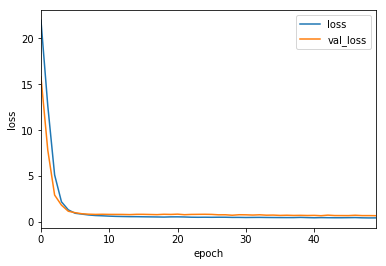

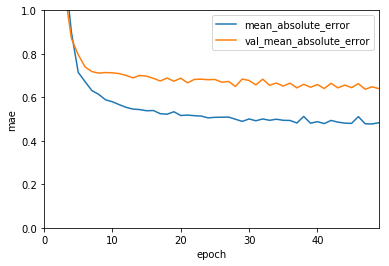

In [33]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20, validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

y_pred = model.predict(X_test)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["mean_absolute_error", "val_mean_absolute_error"]].plot()
plt.ylabel("mae")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

訓練誤差は減っている。
ノードを増やしてみる。

In [34]:
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=13))
model.add(Dense(8, activation='relu', input_dim=10))
model.add(Dense(10, activation='relu', input_dim=8))
model.add(Dense(3, activation='relu', input_dim=10))
model.add(Dense(3, activation='relu', input_dim=3))
model.add(Dense(1, activation='linear'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

# WARNINGが出るが気にしなくて良い

Train on 240 samples, validate on 104 samples
Epoch 1/50
240/240 [==============================] - 1s 3ms/sample - loss: 23.7956 - mean_absolute_error: 4.7388 - val_loss: 17.8550 - val_mean_absolute_error: 4.1161
Epoch 2/50
240/240 [==============================] - 0s 291us/sample - loss: 13.1170 - mean_absolute_error: 3.3167 - val_loss: 3.3240 - val_mean_absolute_error: 1.4771
Epoch 3/50
240/240 [==============================] - 0s 681us/sample - loss: 3.4111 - mean_absolute_error: 1.4069 - val_loss: 2.4143 - val_mean_absolute_error: 1.0499
Epoch 4/50
240/240 [==============================] - 0s 407us/sample - loss: 1.6584 - mean_absolute_error: 0.9732 - val_loss: 1.6636 - val_mean_absolute_error: 0.8921
Epoch 5/50
240/240 [==============================] - 0s 378us/sample - loss: 0.9143 - mean_absolute_error: 0.7036 - val_loss: 1.9073 - val_mean_absolute_error: 0.9787
Epoch 6/50
240/240 [==============================] - 0s 312us/sample - loss: 0.8554 - mean_absolute_error: 0.674

240/240 [==============================] - 0s 378us/sample - loss: 0.5184 - mean_absolute_error: 0.5030 - val_loss: 1.0838 - val_mean_absolute_error: 0.6813
Epoch 50/50
240/240 [==============================] - 0s 349us/sample - loss: 0.5017 - mean_absolute_error: 0.5088 - val_loss: 1.0011 - val_mean_absolute_error: 0.6599


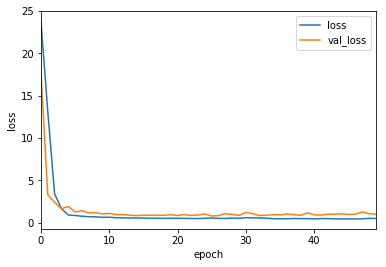

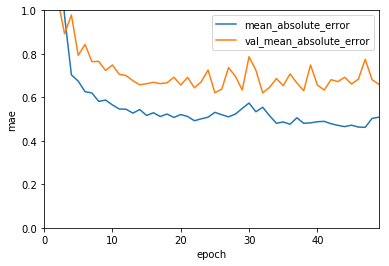

In [35]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20, validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

y_pred = model.predict(X_test)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["mean_absolute_error", "val_mean_absolute_error"]].plot()
plt.ylabel("mae")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

途中いい感じになるときがあった。
ノードの数とインプットアウトプットを変えるだけで結果がかなり影響されるが、どう変えるべきか見当がつかない。

In [36]:
model = Sequential()
model.add(Dense(15, activation='relu', input_dim=13))
model.add(Dense(10, activation='relu', input_dim=15))
model.add(Dense(8, activation='relu', input_dim=10))
model.add(Dense(12, activation='relu', input_dim=8))
model.add(Dense(9, activation='relu', input_dim=12))
model.add(Dense(6, activation='relu', input_dim=9))
model.add(Dense(4, activation='relu', input_dim=6))
model.add(Dense(2, activation='relu', input_dim=4))
model.add(Dense(1, activation='linear'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

# WARNINGが出るが気にしなくて良い

Train on 240 samples, validate on 104 samples
Epoch 1/100
240/240 [==============================] - 1s 4ms/sample - loss: 13.3222 - mean_absolute_error: 3.2577 - val_loss: 13.4002 - val_mean_absolute_error: 2.5439
Epoch 2/100
240/240 [==============================] - 0s 461us/sample - loss: 5.3038 - mean_absolute_error: 1.6212 - val_loss: 2.9984 - val_mean_absolute_error: 1.4980
Epoch 3/100
240/240 [==============================] - 0s 432us/sample - loss: 1.9832 - mean_absolute_error: 1.0770 - val_loss: 2.4283 - val_mean_absolute_error: 1.1787
Epoch 4/100
240/240 [==============================] - 0s 428us/sample - loss: 0.9314 - mean_absolute_error: 0.7120 - val_loss: 0.9400 - val_mean_absolute_error: 0.7443
Epoch 5/100
240/240 [==============================] - 0s 449us/sample - loss: 0.7203 - mean_absolute_error: 0.6178 - val_loss: 1.0987 - val_mean_absolute_error: 0.8002
Epoch 6/100
240/240 [==============================] - 0s 432us/sample - loss: 0.6636 - mean_absolute_error: 

Epoch 49/100
240/240 [==============================] - 0s 399us/sample - loss: 0.2871 - mean_absolute_error: 0.3922 - val_loss: 0.6458 - val_mean_absolute_error: 0.6290
Epoch 50/100
240/240 [==============================] - 0s 436us/sample - loss: 0.2898 - mean_absolute_error: 0.3877 - val_loss: 0.6026 - val_mean_absolute_error: 0.6098
Epoch 51/100
240/240 [==============================] - 0s 436us/sample - loss: 0.2408 - mean_absolute_error: 0.3583 - val_loss: 0.5431 - val_mean_absolute_error: 0.5735
Epoch 52/100
240/240 [==============================] - 0s 428us/sample - loss: 0.2704 - mean_absolute_error: 0.3654 - val_loss: 0.5686 - val_mean_absolute_error: 0.5812
Epoch 53/100
240/240 [==============================] - 0s 407us/sample - loss: 0.2469 - mean_absolute_error: 0.3597 - val_loss: 0.5523 - val_mean_absolute_error: 0.5715
Epoch 54/100
240/240 [==============================] - 0s 399us/sample - loss: 0.2475 - mean_absolute_error: 0.3405 - val_loss: 0.6248 - val_mean_abs

240/240 [==============================] - 0s 411us/sample - loss: 0.2051 - mean_absolute_error: 0.3301 - val_loss: 0.6187 - val_mean_absolute_error: 0.5871
Epoch 98/100
240/240 [==============================] - 0s 382us/sample - loss: 0.2252 - mean_absolute_error: 0.3587 - val_loss: 0.6011 - val_mean_absolute_error: 0.5764
Epoch 99/100
240/240 [==============================] - 0s 386us/sample - loss: 0.2201 - mean_absolute_error: 0.3188 - val_loss: 0.5961 - val_mean_absolute_error: 0.5575
Epoch 100/100
240/240 [==============================] - 0s 322us/sample - loss: 0.2908 - mean_absolute_error: 0.3882 - val_loss: 0.5438 - val_mean_absolute_error: 0.5474


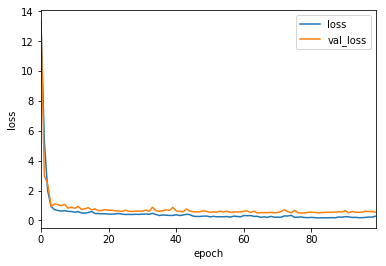

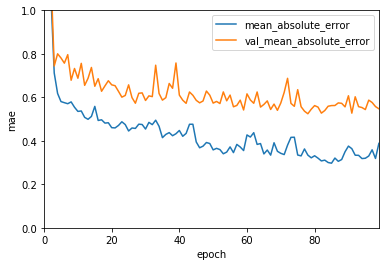

In [37]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=100,
          batch_size=20, validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

y_pred = model.predict(X_test)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["mean_absolute_error", "val_mean_absolute_error"]].plot()
plt.ylabel("mae")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

途中でテスト誤差が0.6を切っている。ノードを増やすほどいいというのはこういうことなのだろうか。  
→なぜか動かし直したら切らなくなってしまった。

重みもとってみる

In [38]:
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()

weights[0]=
[[ 3.41590703e-01  1.18123077e-01 -8.77967477e-01 -6.44771039e-01
  -4.43370014e-01  3.42223383e-02  7.34028518e-01  5.47067761e-01
  -2.82735646e-01  1.77418783e-01  1.48270100e-01  5.63565731e-01
  -3.04921269e-01  1.81702957e-01  5.52944005e-01]
 [ 4.57082301e-01  2.65400738e-01  4.38773096e-01  2.11994216e-01
  -1.97484732e-01  3.66723508e-01  1.28948852e-01 -2.44249612e-01
   4.42372143e-01  2.27669701e-01 -3.06065083e-01  5.53433180e-01
  -4.79283854e-02  4.87758487e-01 -1.39916465e-01]
 [ 3.93427640e-01  3.95230055e-02 -4.57237452e-01  7.93316364e-02
  -2.23334238e-01  2.54415363e-01 -3.26742113e-01  3.95144522e-01
  -3.57958317e-01 -4.34163213e-03 -2.71121830e-01  1.08226128e-01
   1.62443653e-01 -2.28135228e-01 -4.36168045e-01]
 [-9.23930332e-02 -8.51649523e-01 -3.64130825e-01  2.83440113e-01
   1.21958211e-01 -3.10218632e-01 -4.88545924e-01  6.97779935e-03
   3.57712120e-01  2.43530691e-01  6.09840930e-01  2.47415692e-01
  -6.57749698e-02  2.57811666e-01 -3.582228

重みを見てもなにもわからなかった。。
今回の考え方はある程度説明可能な機械学習でしか使えないのかもしれない。

In [39]:
model = Sequential()
model.add(Dense(15, activation='relu', input_dim=13))
model.add(Dense(10, activation='relu', input_dim=15))
model.add(Dense(8, activation='relu', input_dim=10))
model.add(Dense(12, activation='relu', input_dim=8))
model.add(Dense(9, activation='relu', input_dim=12))
model.add(Dense(11, activation='relu', input_dim=9))
model.add(Dense(7, activation='relu', input_dim=11))
model.add(Dense(10, activation='relu', input_dim=7))
model.add(Dense(8, activation='relu', input_dim=10))
model.add(Dense(12, activation='relu', input_dim=8))
model.add(Dense(9, activation='relu', input_dim=12))
model.add(Dense(11, activation='relu', input_dim=9))
model.add(Dense(7, activation='relu', input_dim=11))
model.add(Dense(10, activation='relu', input_dim=7))
model.add(Dense(8, activation='relu', input_dim=10))
model.add(Dense(6, activation='relu', input_dim=8))
model.add(Dense(4, activation='relu', input_dim=6))
model.add(Dense(2, activation='relu', input_dim=4))
model.add(Dense(1, activation='linear'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

# WARNINGが出るが気にしなくて良い

Train on 240 samples, validate on 104 samples
Epoch 1/100
240/240 [==============================] - 1s 6ms/sample - loss: 15.0820 - mean_absolute_error: 3.4811 - val_loss: 6.1087 - val_mean_absolute_error: 1.5010
Epoch 2/100
240/240 [==============================] - 0s 417us/sample - loss: 2.2281 - mean_absolute_error: 1.0818 - val_loss: 3.1136 - val_mean_absolute_error: 1.3114
Epoch 3/100
240/240 [==============================] - 0s 483us/sample - loss: 1.2573 - mean_absolute_error: 0.7643 - val_loss: 0.9385 - val_mean_absolute_error: 0.6875
Epoch 4/100
240/240 [==============================] - 0s 418us/sample - loss: 0.9574 - mean_absolute_error: 0.6794 - val_loss: 0.9239 - val_mean_absolute_error: 0.6867
Epoch 5/100
240/240 [==============================] - 0s 418us/sample - loss: 0.8387 - mean_absolute_error: 0.6240 - val_loss: 1.0658 - val_mean_absolute_error: 0.7327
Epoch 6/100
240/240 [==============================] - 0s 418us/sample - loss: 0.7520 - mean_absolute_error: 0

Epoch 49/100
240/240 [==============================] - 0s 765us/sample - loss: 0.2520 - mean_absolute_error: 0.3690 - val_loss: 1.8712 - val_mean_absolute_error: 0.7085
Epoch 50/100
240/240 [==============================] - 0s 686us/sample - loss: 0.4115 - mean_absolute_error: 0.4785 - val_loss: 2.0006 - val_mean_absolute_error: 0.8935
Epoch 51/100
240/240 [==============================] - 0s 544us/sample - loss: 0.3689 - mean_absolute_error: 0.4394 - val_loss: 3.6843 - val_mean_absolute_error: 0.8157
Epoch 52/100
240/240 [==============================] - 0s 519us/sample - loss: 0.3182 - mean_absolute_error: 0.4081 - val_loss: 2.0269 - val_mean_absolute_error: 0.7701
Epoch 53/100
240/240 [==============================] - 0s 594us/sample - loss: 0.2484 - mean_absolute_error: 0.3685 - val_loss: 2.0953 - val_mean_absolute_error: 0.7262
Epoch 54/100
240/240 [==============================] - 0s 603us/sample - loss: 0.2219 - mean_absolute_error: 0.3366 - val_loss: 1.7074 - val_mean_abs

240/240 [==============================] - 0s 483us/sample - loss: 0.1727 - mean_absolute_error: 0.3121 - val_loss: 3.9508 - val_mean_absolute_error: 0.8975
Epoch 98/100
240/240 [==============================] - 0s 790us/sample - loss: 0.1849 - mean_absolute_error: 0.3113 - val_loss: 2.7254 - val_mean_absolute_error: 0.7667
Epoch 99/100
240/240 [==============================] - 0s 418us/sample - loss: 0.2014 - mean_absolute_error: 0.3417 - val_loss: 4.3948 - val_mean_absolute_error: 0.8360
Epoch 100/100
240/240 [==============================] - 0s 418us/sample - loss: 0.2044 - mean_absolute_error: 0.3475 - val_loss: 3.9379 - val_mean_absolute_error: 0.8746


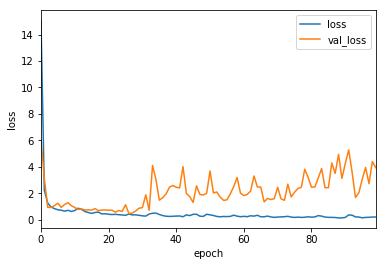

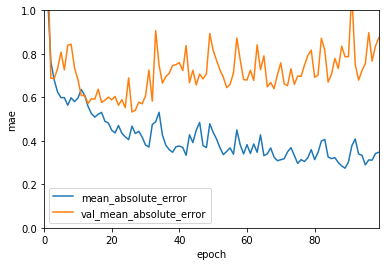

In [40]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=100,
          batch_size=20, validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

y_pred = model.predict(X_test)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["mean_absolute_error", "val_mean_absolute_error"]].plot()
plt.ylabel("mae")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

多ければ絶対にいいということではないらしい

リランする度に結果が変わるのはなぜでしょうか。。。